# API-интерфейс Keras

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pathlib
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
np.set_printoptions(precision=3)

2025-08-04 20:15:52.792100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754327752.825703   10069 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754327752.835713   10069 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754327752.865772   10069 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754327752.865802   10069 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754327752.865805   10069 computation_placer.cc:177] computation placer alr

## Построение линейной регрессионной модели

### Создаем "игрушечный" набора данных

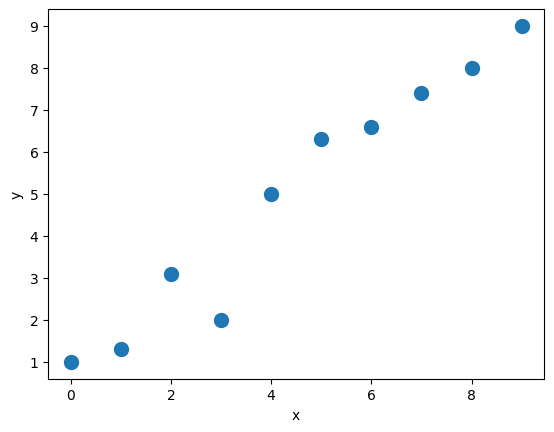

In [3]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Стандартизируем признаки

In [4]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

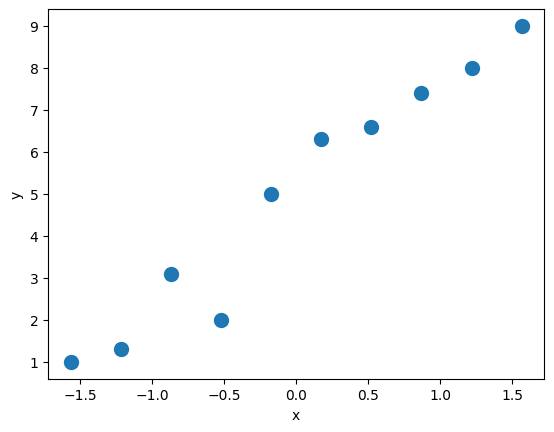

In [6]:
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Создаем объект Dataset

In [8]:
ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
    tf.cast(y_train, tf.float32))
)

E0000 00:00:1754328202.795509   10069 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1754328202.801173   10069 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
tf.cast(X_train_norm, tf.float32)

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[-1.567],
       [-1.219],
       [-0.87 ],
       [-0.522],
       [-0.174],
       [ 0.174],
       [ 0.522],
       [ 0.87 ],
       [ 1.219],
       [ 1.567]], dtype=float32)>

In [13]:
tf.cast(y_train, tf.float32)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1. , 1.3, 3.1, 2. , 5. , 6.3, 6.6, 7.4, 8. , 9. ], dtype=float32)>

In [14]:
ds_train_orig

<_TensorSliceDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

Определим модель для линейной регрессии.
Определим новый класс, производный от класса `tf.keras.Model`.

In [18]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w * x + self.b    

Из класса `MyModel` создадим объект, который можно будет обучать с помощью обучающих данных

In [21]:
model = MyModel()
model.build(input_shape=(None, 1))
model.summary()

Model: "my_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

In [35]:
tf.random.set_seed(1)
num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))

ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count= None)
ds_train = ds_train.batch(1)
Ws, bs = [], []
for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs:
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)

    train(model, bx, by, learning_rate=learning_rate)
    if i%log_steps==0:
        print('Эпоха {:4d} Шаг {:2d} Потеря {:6.4f}'.format(
            int(i/steps_per_epoch), i, loss_val
        ))

Эпоха    0 Шаг  0 Потеря 43.5600
Эпоха   10 Шаг 100 Потеря 0.7530
Эпоха   20 Шаг 200 Потеря 20.1759
Эпоха   30 Шаг 300 Потеря 23.3976
Эпоха   40 Шаг 400 Потеря 6.3481
Эпоха   50 Шаг 500 Потеря 4.6356
Эпоха   60 Шаг 600 Потеря 0.2411
Эпоха   70 Шаг 700 Потеря 0.2036
Эпоха   80 Шаг 800 Потеря 3.8177
Эпоха   90 Шаг 900 Потеря 0.9416
Эпоха  100 Шаг 1000 Потеря 0.7035
Эпоха  110 Шаг 1100 Потеря 0.0348
Эпоха  120 Шаг 1200 Потеря 0.5404
Эпоха  130 Шаг 1300 Потеря 0.1170
Эпоха  140 Шаг 1400 Потеря 0.1195
Эпоха  150 Шаг 1500 Потеря 0.0944
Эпоха  160 Шаг 1600 Потеря 0.4670
Эпоха  170 Шаг 1700 Потеря 2.0695
Эпоха  180 Шаг 1800 Потеря 0.0020
Эпоха  190 Шаг 1900 Потеря 0.3612
